# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [2]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

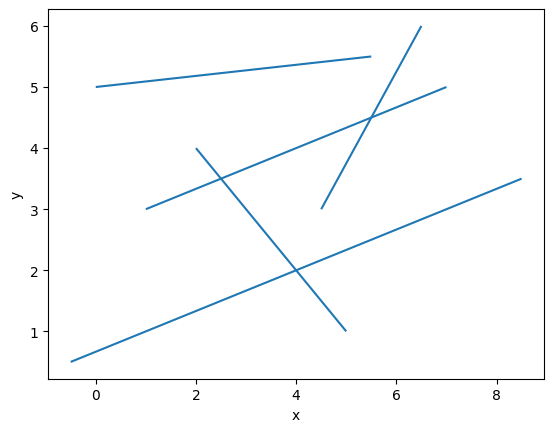

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

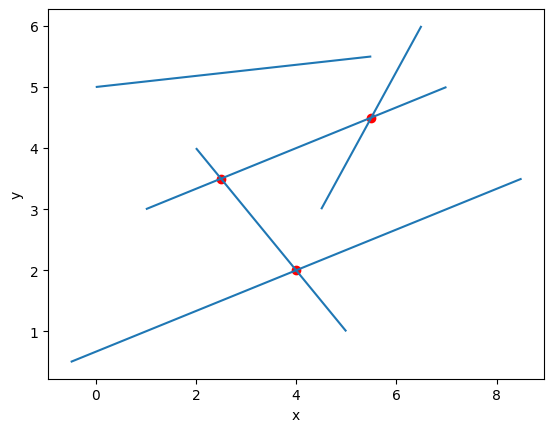

In [4]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    unique_x = np.random.uniform(0, max_x, size=(n,2))
    result = []
    for x1, x2 in unique_x:
        result.append( ((x1,np.random.uniform(0, max_y)), (x2,np.random.uniform(0, max_y))) )
    return result


In [6]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.156s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [7]:
random20segments = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

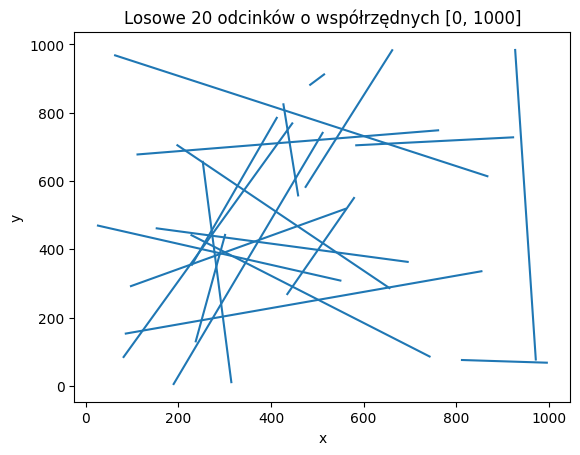

In [8]:
def show_segments(segments, title="None"):
    vis = Visualizer()
    vis.add_title(title)
    vis.add_line_segment(segments)
    return vis
show_segments(random20segments, "Losowe 20 odcinków o współrzędnych [0, 1000]").show()

Uzupełnij funkcję ```is_intersection```

In [9]:
def is_intersection(sections, eps=10 ** (-10)):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    from sortedcontainers import SortedSet
    from queue import PriorityQueue
    
    def det(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    def orient(a, b, c):
        determinant = det(a, b, c)
        if determinant > eps:
            return 1
        elif determinant < -eps:
            return -1
        return 0

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            for i, segment in enumerate(self.segments):
                self.Q.put((segment[0][0], 1, segment))
                self.Q.put((segment[1][0], 0, segment))

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                if event and self.insert(segment):
                    return True
                elif not event and self.delete(segment):
                    return True
            return False

        def insert(self, segment):
            self.T.add(segment)
            index = self.T.index(segment)
            a = b = False
            if index > 0:
                a = self.check(segment, self.T[index-1])
            if index+1 < len(self.T):
                b = self.check(segment, self.T[index+1])
            return a or b

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            return self.check(self.T[index], self.T[index-1]) if 0 < index < len(self.T)-1 else False

        def check(self, segment1, segment2):
            a, b = segment1
            c, d = segment2
            if orient(a, b, c) != orient(a, b, d) and orient(c, d, a) != orient(c, d, b):
                return True
            return False
    
    return Broom(sections).sweep()


In [10]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.016s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [13]:
def is_intersection_with_visualization(sections, eps=10**(-12), title="None"):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    global glob
    from queue import PriorityQueue
    from sortedcontainers import SortedSet
    
    def det(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    def orient(a, b, c):
        determinant = det(a, b, c)
        if determinant > eps:
            return 1
        elif determinant < -eps:
            return -1
        return 0

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            for i, segment in enumerate(self.segments):
                self.Q.put((segment[0][0], 1, segment))
                self.Q.put((segment[1][0], 0, segment))
            self.stage = {}
            self.broom = None
            self.point = None
            self.low = min(min(b,d) for (_,b), (_,d)  in  self.segments)
            self.top = max(max(b,d) for (_,b), (_,d)  in  self.segments)

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                self.broom = vis.add_line(((x,self.low),(x,self.top)), color='red')
                if event:
                    self.point = vis.add_point(segment[0], color='red')
                else:
                    self.point = vis.add_point(segment[1], color='red')
                if event and self.insert(segment):
                    return True
                elif not event and self.delete(segment):
                    return True
                vis.remove_figure(self.broom)
                vis.remove_figure(self.point)
            return False

        def insert(self, segment):
            self.T.add(segment)
            index = self.T.index(segment)
            self.stage[segment] = vis.add_line_segment(segment, color='orange')
            a = b = False
            if index > 0:
                a = self.check(segment, self.T[index-1])
            if index+1 < len(self.T):
                b = self.check(segment, self.T[index+1])
            return a or b

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            vis.remove_figure(self.stage[segment])
            return self.check(self.T[index], self.T[index-1]) if 0 < index < len(self.T)-1 else False

        def check(self, segment1, segment2):
            a, b = segment1
            c, d = segment2
            orient11 = orient(a, b, c)
            orient12 = orient(a, b, d)
            orient21 = orient(c, d, a)
            orient22 = orient(c, d, b)
            if orient11 != orient12 and orient21 != orient22:
                vis.add_line_segment((segment1, segment2), color='red')
                return True
            return False
    
    broom = Broom(sections)
    vis = Visualizer()
    vis.add_title(title)
    vis.add_line_segment(sections, color='blue')
    result = broom.sweep()
    vis.save_gif(interval=300, filename=str(glob))
    glob+=1
    return result

In [14]:
glob = 1
Test().runtest(2, is_intersection_with_visualization)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 7.797s


Uzupełnij funkcję ```find_intersections```

In [73]:
def find_intersections(sections, eps=10**(-12)):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    from sortedcontainers import SortedSet
    from queue import PriorityQueue
    
    def det(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    def orient(a, b, c):
        determinant = det(a, b, c)
        if determinant > eps:
            return 1
        elif determinant < -eps:
            return -1
        return 0

    def get_y(x, line):
        a = (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])
        b = line[1][1] - a * line[1][0]
        return a * x + b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            self.intersections = set()
            self.inter_lines = set()
            for i, segment in enumerate(self.segments):
                self.Q.put((segment[0][0], 1, segment))
                self.Q.put((segment[1][0], -1, segment))
            
        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                if event == 1:
                    self.insert(segment)
                elif event == -1:
                    self.delete(segment)
                else:
                    self.change(segment, x)
            return self.intersections

        def insert(self, segment):
            self.T.add(segment)
            index = self.T.index(segment)
            if index > 0:
                p = self.check(segment, self.T[index-1])
                mini, maxi = min(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini,maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index-1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
            if index+1 < len(self.T):
                p = self.check(segment, self.T[index+1])
                mini, maxi = min(self.segments.index(self.T[index+1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index+1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini, maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index+1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
            return

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            if 0 < index < len(self.T)-1:
                p = self.check(self.T[index], self.T[index-1])
                mini, maxi = min(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini,maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index-1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
            return
            
        def change(self, segment, x):
            ind1 = self.T.index(segment[0])
            self.T.pop(ind1)
            ind2 = self.T.index(segment[1])
            self.T.pop(ind2)
            
            temp = SortedSet(key=lambda line: get_y(x+eps, line))
            temp.update(self.T)
            self.T = temp
            
            self.insert(segment[0])
            self.insert(segment[1])
            return
            
        def check(self, segment1, segment2):
            a, b = segment1
            c, d = segment2
            if orient(a, b, c) != orient(a, b, d) and orient(c, d, a) != orient(c, d, b):
                a_1 = (b[1] - a[1]) / (b[0] - a[0])
                b_1 = a[1] - a_1 * a[0]
                a_2 = (d[1] - c[1]) / (d[0] - c[0])
                b_2 = c[1] - a_2 * c[0]
                x = (b_2 - b_1) / (a_1 - a_2)
                y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1
                return (x, y)
            return None

    return Broom(sections).sweep()

In [69]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.016s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [70]:
def find_intersections_with_visualization(sections, eps=10**(-12)):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    from sortedcontainers import SortedSet
    from queue import PriorityQueue
    global glob
    
    def det(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    def orient(a, b, c):
        determinant = det(a, b, c)
        if determinant > eps:
            return 1
        elif determinant < -eps:
            return -1
        return 0

    def get_y(x, line):
        a = (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])
        b = line[1][1] - a * line[1][0]
        return a * x + b

    class Broom:
        def __init__(self, segments):
            self.segments = segments
            self.Q = PriorityQueue()
            self.T = SortedSet()
            self.intersections = set()
            self.inter_lines = set()
            for i, segment in enumerate(self.segments):
                self.Q.put((segment[0][0], 1, segment))
                self.Q.put((segment[1][0], -1, segment))
            self.stage = {}
            self.line = None
            self.point = None
            self.low = min(min(b,d) for (_,b), (_,d)  in  self.segments)
            self.top = max(max(b,d) for (_,b), (_,d)  in  self.segments)

        def sweep(self):
            while not self.Q.empty():
                x, event, segment = self.Q.get()
                #print(x, event)
                #print(self.intersections)
                self.line = vis.add_line_segment(((x, self.low), (x, self.top)), color='red')
                if event == 1:
                    self.point = vis.add_point(segment[0], color='red')
                elif event == -1:
                    self.point = vis.add_point(segment[1], color='red')
                else:
                    self.point = None
                if event == 1:
                    self.insert(segment)
                elif event == -1:
                    self.delete(segment)
                else:
                    self.change(segment, x)
                if self.point is not None: vis.remove_figure(self.point)
                vis.remove_figure(self.line)
            return self.intersections

        def insert(self, segment, again=False):
            self.T.add(segment)
            if not again: self.stage[segment] = vis.add_line_segment(segment, color='orange')
            index = self.T.index(segment)
            if index > 0:
                p = self.check(segment, self.T[index-1])
                mini, maxi = min(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini,maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index-1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
                    vis.add_point(p, color = 'red')
            if index+1 < len(self.T):
                p = self.check(segment, self.T[index+1])
                mini, maxi = min(self.segments.index(self.T[index+1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index+1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini, maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index+1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
                    vis.add_point(p, color = 'red')
            return

        def delete(self, segment):
            index = self.T.index(segment)
            self.T.pop(index)
            vis.remove_figure(self.stage[segment])
            if 0 < index < len(self.T)-1:
                p = self.check(self.T[index], self.T[index-1])
                mini, maxi = min(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1), max(self.segments.index(self.T[index-1])+1, self.segments.index(self.T[index])+1)
                cross = (p, mini, maxi)
                if p and (mini,maxi) not in self.inter_lines:
                    self.Q.put((p[0], 0, (segment, self.T[index-1])))
                    self.intersections.add(cross)
                    self.inter_lines.add((mini, maxi))
                    vis.add_point(p, color = 'red')
            return
            
        def change(self, segment, x):
            ind1 = self.T.index(segment[0])
            self.T.pop(ind1)
            ind2 = self.T.index(segment[1])
            self.T.pop(ind2)
            
            temp = SortedSet(key=lambda line: get_y(x+eps, line))
            temp.update(self.T)
            self.T = temp
            
            self.insert(segment[0], True)
            self.insert(segment[1], True)
            return
            
        def check(self, segment1, segment2):
            a, b = segment1
            c, d = segment2
            if orient(a, b, c) != orient(a, b, d) and orient(c, d, a) != orient(c, d, b):
                a_1 = (b[1] - a[1]) / (b[0] - a[0])
                b_1 = a[1] - a_1 * a[0]
                a_2 = (d[1] - c[1]) / (d[0] - c[0])
                b_2 = c[1] - a_2 * c[0]
                x = (b_2 - b_1) / (a_1 - a_2)
                y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1
                return (x, y)
            return None

    b = Broom(sections)
    vis = Visualizer()
    vis.add_line_segment(sections, color='blue')
    result = b.sweep()
    vis.save_gif(filename=str(glob), interval=500)
    glob += 1
    return result

In [72]:
glob = 6
Test().runtest(3, find_intersections_with_visualization)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 13.875s


### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.